In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp

# Load simple ODE


In [4]:
def hysteresis_ode(t,x,lam):
    return lam+x-x**3

def simulate_branch(lam_values, x0):
    x_vals = []
    x_curr = x0
    for lam in tqdm(lam_values):
        sol = solve_ivp(hysteresis_ode, [0, 50], [x_curr], args=(lam,), t_eval=[50])
        x_curr = sol.y[0, -1]  # final value
        x_vals.append(x_curr)
    return np.array(x_vals)

In [5]:
lam_start = -1 
lam_end = 1

lam_up = np.linspace(lam_start, lam_end, 250)
lam_down = np.linspace(lam_end, lam_start, 250)

In [6]:
x0=-1
x_increase = simulate_branch(lam_up, x0)
x_decrease = simulate_branch(lam_down,x_increase[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

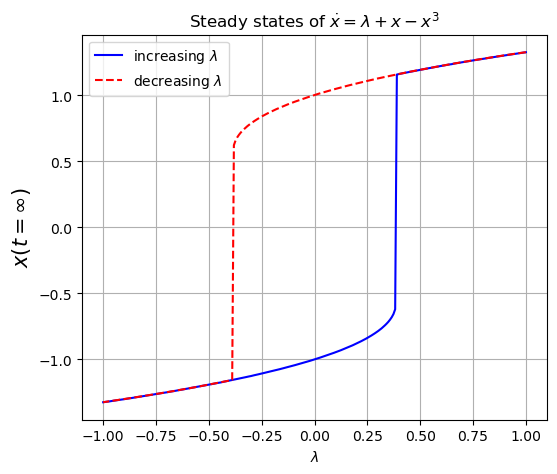

In [7]:

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_up, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_down, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

In [8]:
X = np.hstack((x_increase, x_decrease))
X = np.hstack((X,X))

lam_vals  = np.hstack((lam_up,lam_down))
lam_vals = np.hstack((lam_vals,lam_vals))

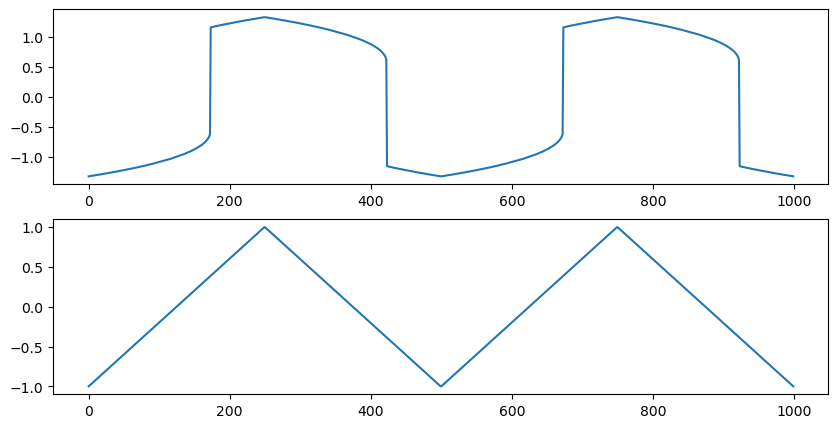

In [9]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(X)
ax[1].plot(lam_vals)
plt.show()

# Neuro ODE approach

In [10]:
import numpy as np

import torch 
import torch.nn as nn
from torchdiffeq import odeint

In [11]:
def lam_func(t):
    lam_vals = np.hstack((lam_up,lam_down))
    idx = int(t) % len(lam_vals)
    return torch.tensor(lam_vals[idx])

In [12]:
class FTerm(nn.Module):
    def __init__(self,dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )
    def forward(self,x):
        return - torch.exp(self.network(x))


class GTerm(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )

    def forward(self, x, u):
        xu = torch.cat([x,u],dim=-1)
        return self.network(xu)


class ODEModel(nn.Module):
    def __init__(self,f,g):
        super().__init__()
        self.f = f
        self.g = g

    def forward(self, t, state, u_func):
        x = state
        u = u_func(t).unsqueeze(0).unsqueeze(1)
        fx = self.f(x)
        gx = self.g(x,u)
        return f(x)*(x-gx)

In [13]:
x0 = torch.tensor([[-1.0]], requires_grad=True)
dim_in = 1
dim_out = 1
f = FTerm(dim_in, dim_out)
g = GTerm(dim_in, dim_out)

ode_model = ODEModel(f,g)


In [14]:
t_span = torch.arange(1000,dtype=torch.float32)

In [ ]:
x_pred = odeint(lambda t, x: ode_model(t,x,lam_func),x0,t_span)

In [ ]:
x_pred

In [ ]:
plt.plot(t_span, lam_func(t_span))